![li_banner_1_blue.png](./OI_images/li_banner_1_blue.png)

# Proteox system integration with QCoDeS

The Proteox is controlled with the `oi.DECS` system control software.  This is designed to operate in an asynchronous fashion using WebSockets.

`QCoDeS` works well for `VISA` instruments that generally have synchronous behaviour.

It is possible to the `WAMP` messaging protocol directly from QCoDeS, but for simple (single threaded) instrument drivers that can result in time-out issues if the communication channel is unactive for some time.

An alternative approach is to make `oi.DECS` 'look like' a standard `VISA` instrument, and that approach is described below.

## DECS<->VISA

To accomplish this, a simple socket server (launched *via* `decs_visa.py`) is inserted between `QCoDeS` and `oi.DECS`.  A pair of queues objects are provided for inter-process communication between the socket server and the `WAMP` interface to the Proteox.

![DECS_VISA.jpg](./OI_images/DECS_VISA.jpg)

## Example of Proteox Control using QCoDeS driver

First, import the required python packages and Proteox oi.DECS QCoDeS driver, starting logging and create a Station.

In [1]:
import logging

import qcodes as qc
from qcodes.logger.logger import start_all_logging

from qcodes_contrib_drivers.drivers.OxfordInstruments.Proteox import oiDECS

start_all_logging()
log = logging.getLogger()

station = qc.Station()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\abi.graham\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\abi.graham\.qcodes\logs\240523-21260-qcodes.log


**Initialise connection to oi.DECS software/Proteox.**

If running on a Windows platform, debug/information produced by the `DECS<->VISA` simple TCP socket server will be outputted to a `decs_visa.log file` created in your working directory. If struggling to establish a connection please check this log file for information on why.

In [2]:
try:
    Proteox = oiDECS('Proteox')
    Proteox.timeout(15)
except Exception as err:
    log.critical(err)
    print(f'Connection failed: {err}')

Running on Windows-10-10.0.19045-SP0 - start subprocess without PIPEd output
Connected to: Oxford Instruments oi.DECS (serial:decs-544e0a, firmware:0.6.0.2621) in 0.15s


**Add Proteox to QCoDeS station and print readable snapshot of cryostat.**

In [3]:
station.add_component(Proteox)
Proteox.print_readable_snapshot()

Proteox:
	parameter                  value
--------------------------------------------------------------------------------
Cold_Plate_Temperature      :	0 (K)
IDN                         :	{'vendor': 'Oxford Instruments', 'model': 'oi:D...
Magnet_Current_Vector       :	(0.0, 0.0, -0.0116) (('A', 'A', 'A'))
Magnet_State                :	Holding Persistent 
Magnet_Temperature          :	813.1 (K)
Magnetic_Field_Vector       :	(0.0, 0.0, 0.0) (('T', 'T', 'T'))
Mixing_Chamber_Heater_Power :	0 (W)
Mixing_Chamber_Temperature  :	0 (K)
OVC_Pressure                :	2440 (Pa)
P1_Pressure                 :	87013 (Pa)
P2_Pressure                 :	171 (Pa)
P3_Pressure                 :	430 (Pa)
P4_Pressure                 :	33656 (Pa)
P5_Pressure                 :	34647 (Pa)
P6_Pressure                 :	451.9 (Pa)
PT1_Head_Temperature        :	294.3 (K)
PT1_Plate_Temperature       :	294.24 (K)
PT2_Head_Temperature        :	294.01 (K)
PT2_Plate_Temperature       :	294.03 (K)
Sorb_Temperature    

**Read Parameters**

In [3]:
Proteox.Mixing_Chamber_Temperature()

1.9693

In [3]:
Proteox.Magnetic_Field_Vector()

(0.0, 0.0, -0.000215296835037395)

In [4]:
Proteox.Magnetic_Field_Vector()[2]

-0.000215296835037395

### Magnet Control

In [7]:
Proteox.Magnet_State()

'Holding Persistent'

**Set target field value and ramp rate.** 

````python
set_magnet_target(
  Coordinate_system : int, 
  X_feild_value : float, 
  Y_field_value : float, 
  Z_field_value : float, 
  Sweep_mode : str, 
  Sweep_rate : float,
  Persist_on_completion : bool
)
````

Options for coordinate system are:  

  0 - Cartesian (X,Y,Z)  
  10 - Cylinderical (Rho, Phi, Z)  
  20 - Sphereical (R,Theta,Phi)  

For a solenoid magnet X_field_value and Y_field_value should be set to zero.

Options for Sweep_mode (and Sweep_rate) are: 
 
  'ASAP' (Sweep_rate is ignored. Can be any float)  
  'TIME' (Sweep_rate = time in minutes)   
  'RATE' (Sweep_rate = rate in T/min)   

In [8]:
#for z-solenoid magnet set target field to 0.1 T and sweep rate to 0.25 T/min.
Proteox.set_magnet_target(0,0,0,0,'RATE',0.25,False)

#If running with oi.DECS firmware =< 0.5.1, ingore the error "Error parsing response: Length of data record inconsistent with record type". The magnet field target should have still been set. Check the GUI.
#You will recieve this error because the data sent back from oi.DECS won't be handled correctly for firmware versions =< 0.5.1.

Sweep the field. Then wait until Magnet status has gone back to 'Holding Not Persistent'.

In [ ]:
Proteox.sweep_field()
Proteox.wait_until_field_stable()

For high resolution field sweeps, set the target field as normal, then use the `sweep_small_field_step` function, instead of `sweep_field`.

The `sweep_small_field_step` function is required when you want to step the output current of the magnet power supply by less than 100 mA. The iPS has an output current resolution of 0.1 mA. The function `sweep_field` shown above only provides a output current resolution of 100 mA, due to the oi.DECS API used in this function.

*(What 100 mA is in magnetic field will depend on the current to field conversion factor of your magnet. This value can be found on your iPS under **Config** and under the column heading **I to H (A/T)**.)*

In [ ]:
Proteox.set_magnet_target(0,0,0,0.005,'ASAP',0.25,False)
Proteox.sweep_small_field_step('Z')

# You can only ramp one sub-group (X,Y or Z) at a time.
# When ramping the VRM subgroup the GUI will continue to show the VRM status as ‘Holding Not Persistent’ but the iPS will ramp the current to your field set point.
# The field value displayed on the GUI always rounds to 2 decimal places, but if you use the API to ask for the field value, it gives you the correct more precise value.

### 2D measurement example using do2d

Starting experimental run with id: 2. Using 'qcodes.dataset.do2d'


  0%|          | 0/3 [00:00<?, ?it/s]

Sweeping Field
Status: Holding Not Persistent.
Waiting for temperature to stablilise at 2.0 K.
Temperature = 1.9909 K
Temperature stable after 31 seconds. (Mean-Target = 0.019863333333333344 K, StdDev = 0.008160411890476027 K)


  0%|          | 0/3 [00:00<?, ?it/s]

Sweeping Field
Status: Holding Not Persistent.
Sweeping Field
Status: Holding Not Persistent.
Sweeping Field
Status: Holding Not Persistent.
Waiting for temperature to stablilise at 3.0 K.
Temperature = 3.0094 K
Temperature stable after 106 seconds. (Mean-Target = 0.007279999999999731 K, StdDev = 0.009747936533783237 K)


  0%|          | 0/3 [00:00<?, ?it/s]

Sweeping Field
Status: Holding Not Persistent.
Sweeping Field
Status: Holding Not Persistent.
Sweeping Field
Status: Holding Not Persistent.
Waiting for temperature to stablilise at 4.0 K.
Temperature = 4.0101 K
Temperature stable after 102 seconds. (Mean-Target = 0.001926666666665966 K, StdDev = 0.009894676458693501 K)


  0%|          | 0/3 [00:00<?, ?it/s]

Sweeping Field
Status: Holding Not Persistent.
Sweeping Field
Status: Holding Not Persistent.


(results #2@C:\Users\abi.graham\experiments.db
 ---------------------------------------------
 MC_Temperature - numeric
 Magnetic_Field_Z - numeric
 Etime - numeric,
 (<Axes: title={'center': 'Run #2, Experiment doNd_Measurement (no sample)'}, xlabel='MC_Temperature (K)', ylabel='Magnetic_Field_Z (mT)'>,),
 (<matplotlib.colorbar.Colorbar at 0x1c1331caa20>,))

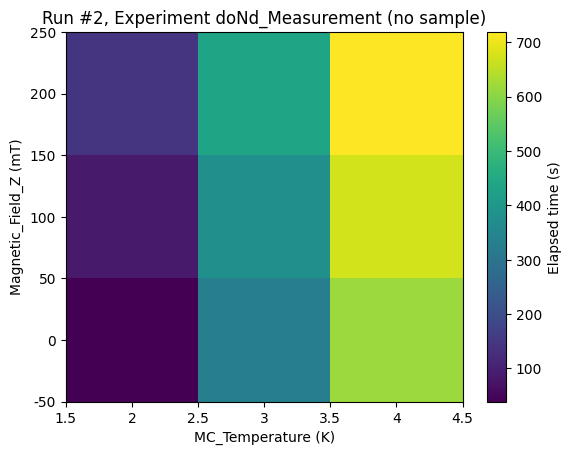

In [3]:
from qcodes.dataset import do2d
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset import load_or_create_experiment, Measurement

tutorial_exp = load_or_create_experiment("doNd_Measurement", sample_name="no sample")
meas = Measurement(name="2d_measurement", exp=tutorial_exp)

# create a function that sets the temperature and waits until stable
def Mixing_Chamber_Temperature_set(temp):
    Proteox.Mixing_Chamber_Temperature(temp)
    Proteox.wait_until_temperature_stable_std_control(0.02, 0.01, 1)

# use above function as temperature setting parameter
set_Mixing_Chamber_Temperature = qc.Parameter('MC_Temperature',
                        label='MC_Temperature',
                        unit='K',
                        set_cmd=Mixing_Chamber_Temperature_set)

# create a function that sets the magnetic field and waits until stable
def Magnetic_Field_Z_set(tesla):
    Proteox.set_magnet_target(0,0,0,tesla,'RATE',0.3,False)
    Proteox.sweep_field()
    Proteox.wait_until_field_stable()

# use above function as the magnetic field setting parameter
set_Magnetic_Field_Z = qc.Parameter('Magnetic_Field_Z',
                        label='Magnetic_Field_Z',
                        unit='T',
                        set_cmd=Magnetic_Field_Z_set)

# parameter to be measured at each temperature and field value.
Etime = ElapsedTimeParameter('Etime')

do2d(
    set_Mixing_Chamber_Temperature,
    2,
    4,
    3,
    0.01,
    set_Magnetic_Field_Z,
    0,
    0.2,
    3,
    0.01,
    Etime,
    do_plot=True,
    show_progress=True
)

**Close connection to oiDECS/Proteox**

In [4]:
Proteox.close()

![nanoscience.png](./OI_images/nanoscience.png)